## Raven Memory benchmarking

The following is meant to observe the memory performance in a more verbose logging mode, for the baseline raven models

## Setup

In [ ]:
# Due to the size of the CSV data, we did not include it in the repository. You can download our current CSV data from hugging face
!mkdir -p ./logs

# Raven models
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-1B5-v12.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-3B-v12.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-7B-v12.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Raven-14B-v12.csv

# Experimental RWKv4neo models
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/Echo-B-1B4-Tune3-L96-D1024.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/TokenShift-A-Tune4.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/TokenShift-B-Tune4.csv
!cd ./logs && wget -nc https://huggingface.co/picocreator/memory-size-experiment-for-rwkv/raw/main/memory-benchmark-logs/TokenShift-C-Tune4.csv

In [ ]:
# Install required pip libraries
!python -m pip install matplotlib

## Loading of CSV data

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)

# Load the CSV data
raven_1b5 = pd.read_csv("./logs/Raven-1B5-v12.csv")
raven_3b  = pd.read_csv("./logs/Raven-3B-v12.csv")
raven_7b  = pd.read_csv("./logs/Raven-7B-v12.csv")
raven_14b  = pd.read_csv("./logs/Raven-14B-v12.csv")

echoB_1b4  = pd.read_csv("./logs/Echo-B-1B4-Tune3-L96-D1024.csv")
tshiftA_1B3  = pd.read_csv("./logs/TokenShift-A-Tune4.csv")
tshiftB_430M  = pd.read_csv("./logs/TokenShift-B-Tune4.csv")
tshiftC_1B5  = pd.read_csv("./logs/TokenShift-C-Tune4.csv")

raven_1b5

,eval_token_count,token_idx,matched,top_token_str,top_token_percentage,eval_token_str,eval_token_pos,eval_token_percentage,is_random_baseline
0,5,0,True,ad,0.927549,ad,0,0.927549,False
1,5,1,True,jective,0.981719,jective,0,0.981719,False
2,5,2,True,we,0.921380,we,0,0.921380,False
3,5,3,True,shallow,0.936524,shallow,0,0.936524,False
4,5,4,True,become,0.842697,become,0,0.842697,False
...,...,...,...,...,...,...,...,...,...
19220,1000,995,False,figure,0.004160,window,260,0.000731,True
19221,1000,996,False,morning,0.004311,course,295,0.000699,True
19222,1000,997,False,morning,0.006757,serious,1389,0.000160,True
19223,1000,998,False,figure,0.004934,applied,2789,0.000061,True


In [143]:
# Define a custom function to calculate averages for the first N elements
def calculate_first_n_avg(n, s):
    return s.iloc[:n].mean()

# Groupby the 'eval_token_count' and calculate the average for the first 5, 10, and 20 'eval_token_pos'
def group_csv_data(inCSV, modelName):
    grouped_data = inCSV.groupby(['eval_token_count', 'is_random_baseline']).apply(lambda x: pd.Series({
        'First 1 tokens average': calculate_first_n_avg(1, x['eval_token_pos']),
        'First 2 tokens average': calculate_first_n_avg(2, x['eval_token_pos']),
        'First 5 tokens average': calculate_first_n_avg(5, x['eval_token_pos']),
        'First 10 tokens average': calculate_first_n_avg(10, x['eval_token_pos']),
        'First 25 tokens average': calculate_first_n_avg(25, x['eval_token_pos']),
        'First 50 tokens average': calculate_first_n_avg(50, x['eval_token_pos']),
        'First 100 tokens average': calculate_first_n_avg(100, x['eval_token_pos']),
        'First 250 tokens average': calculate_first_n_avg(250, x['eval_token_pos']),
        'First 500 tokens average': calculate_first_n_avg(500, x['eval_token_pos']),
        'First 750 tokens average': calculate_first_n_avg(750, x['eval_token_pos']),
        'First 1000 tokens average': calculate_first_n_avg(1000, x['eval_token_pos']),
        "match_count": x["matched"].sum(),
        "match_percentage": x["matched"].sum() * 100.0 / x["matched"].count() ,
    })).reset_index()
    grouped_data['model'] = modelName
    return grouped_data

# Merge the DataFrames 
full_grouped_data = pd.concat([
    group_csv_data(raven_1b5, 'Raven 1B5'),
    group_csv_data(raven_3b, 'Raven 3B'),
    group_csv_data(raven_7b, 'Raven 7B'),
    group_csv_data(raven_14b, 'Raven 14B'),

    group_csv_data(echoB_1b4, 'EchoB 1B4 (L96)'),
    group_csv_data(tshiftA_1B3, 'TokenShiftA 1B4 (L12-D2560)'),
    group_csv_data(tshiftB_430M, 'TokenShiftB 430M (L24-D1024)'),
    group_csv_data(tshiftC_1B5, 'TokenShiftC 1B5 (L24-D2048)'),
])

# Plot the data
full_grouped_data

,eval_token_count,is_random_baseline,First 1 tokens average,First 2 tokens average,First 5 tokens average,First 10 tokens average,First 25 tokens average,First 50 tokens average,First 100 tokens average,First 250 tokens average,First 500 tokens average,First 750 tokens average,First 1000 tokens average,match_count,match_percentage,model
0,5,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,100.000000,Raven 1B5
1,10,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0,100.000000,Raven 1B5
2,15,False,0.0,0.0,0.0,0.0,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,0.133333,14.0,93.333333,Raven 1B5
3,20,False,0.0,0.0,0.0,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,19.0,95.000000,Raven 1B5
4,25,False,0.0,0.0,0.0,0.0,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,23.0,92.000000,Raven 1B5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,850,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.072000,0.534000,1.022667,1.052941,703.0,82.705882,TokenShiftC 1B5 (L24-D2048)
64,900,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.064000,0.482000,1.310667,1.692222,708.0,78.666667,TokenShiftC 1B5 (L24-D2048)
65,950,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.072000,0.512000,2.104000,3.118947,704.0,74.105263,TokenShiftC 1B5 (L24-D2048)
66,1000,False,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.120000,0.528000,2.682667,4.758000,709.0,70.900000,TokenShiftC 1B5 (L24-D2048)


In [144]:
# We get the position values, of the average token prediction, withou ONLY the output.
# this helps get the approximate "random" score baseline, while accounting for the fact that the model may eventually notice patterns that makes it not truely random
# (eg. no special characters, etc), as the sample grows.

# Filter out for noise baseline
random_baseline = full_grouped_data[full_grouped_data['is_random_baseline'] == True]

# Geet the average first 1000 tokens for all models
random_baseline_pos = random_baseline.groupby(['model']).mean()['First 1000 tokens average']["Raven 1B5"]
half_random_base_line_pos = random_baseline_pos / 2

print("random_baseline_pos", random_baseline_pos)
print("half_random_base_line_pos", half_random_base_line_pos)

# Get the specialize model randomized baseline
special_random_baseline_pos = random_baseline.groupby(['model']).mean()['First 1000 tokens average']["EchoB 1B4 (L96)"]
special_half_random_base_line_pos = special_random_baseline_pos / 2

print("special_random_baseline_pos", special_random_baseline_pos)
print("special_half_random_base_line_pos", special_half_random_base_line_pos)

# Give the randomized baseline values
random_baseline

random_baseline_pos 1665.979
half_random_base_line_pos 832.9895
special_random_baseline_pos 942.793
special_half_random_base_line_pos 471.3965


,eval_token_count,is_random_baseline,First 1 tokens average,First 2 tokens average,First 5 tokens average,First 10 tokens average,First 25 tokens average,First 50 tokens average,First 100 tokens average,First 250 tokens average,First 500 tokens average,First 750 tokens average,First 1000 tokens average,match_count,match_percentage,model
66,1000,True,1188.0,597.0,5775.4,3777.9,2974.16,2219.60,1830.49,1808.140,1705.120,1693.132000,1665.979,25.0,2.5,Raven 1B5
66,1000,True,1813.0,910.5,4843.8,3640.0,2973.68,2270.46,1834.36,1873.672,1759.384,1718.648000,1661.297,25.0,2.5,Raven 3B
66,1000,True,1159.0,592.0,1804.0,2224.3,2468.96,2062.82,1724.78,1842.436,1700.870,1678.028000,1628.807,27.0,2.7,Raven 7B
67,1000,True,1102.0,552.5,2508.4,2239.4,2174.64,1913.96,1645.39,1790.012,1660.326,1601.150667,1557.255,26.0,2.6,Raven 14B
67,1000,True,3897.0,1949.5,1512.4,1242.2,1034.80,972.60,941.56,930.616,924.262,933.157333,942.793,28.0,2.8,EchoB 1B4 (L96)
67,1000,True,1426.0,973.0,1767.0,1457.3,1384.68,1146.72,1134.52,1073.604,1036.906,1011.653333,984.150,8.0,0.8,TokenShiftA 1B4 (L12-D2560)
67,1000,True,2236.0,1718.5,4053.0,6939.6,4799.56,4362.16,2820.96,1728.688,1434.858,1280.124000,1195.901,19.0,1.9,TokenShiftB 430M (L24-D1024)
67,1000,True,1545.0,772.5,551.8,2460.8,1985.84,2944.50,2801.60,2655.844,1995.600,1671.574667,1482.144,19.0,1.9,TokenShiftC 1B5 (L24-D2048)


In [145]:
# Graphing function
def plotGrapData(sizeArr=[2], redline=False):
    # Lets join the size array, to a single str for logging
    sizeStr = ", ".join([str(x) for x in sizeArr])

    # Plot the axis
    fig, ax = plt.subplots(figsize=(15,7)) #

    # Plot the data, excluding is random baseline = true
    for key, grp in full_grouped_data[full_grouped_data['is_random_baseline'] == False].groupby('model'):
        if len(sizeArr) == 1:
            ax = grp.plot(
                ax=ax, kind='line', x='eval_token_count', 
                y=f'First {sizeArr[0]} tokens average', 
                label=f'{key}'
            )
        else:
            ax = grp.plot(
                ax=ax, kind='line', x='eval_token_count', 
                y=f'First {sizeArr[0]} tokens average', 
                label=f'{key} - First {sizeArr[0]} tokens average'
            )

        if len(sizeArr) >= 2:
            ax = grp.plot(
                ax=ax, kind='line', x='eval_token_count',
                y=f'First {sizeArr[1]} tokens average', 
                label=f'{key} - First {sizeArr[1]} tokens average', linestyle='dashed'
            )

        if len(sizeArr) >= 3:
            ax = grp.plot(ax=ax, kind='line', x='eval_token_count', 
                          y=f'First {sizeArr[2]} tokens average', 
                          label=f'{key} - First {sizeArr[2]} tokens average', linestyle='dotted'
            )

    # Add redline if set
    if redline != False:
        ax.axhline(y=half_random_base_line_pos, color='r', linestyle='-.', label='50 percent of Raven Randomized baseline')
        ax.axhline(y=special_half_random_base_line_pos, color='r', linestyle=':', label='50 percent of Specialized Model Randomized baseline')

    # Title overwrites?
    ax.set_title(f'Recall of the first {sizeStr} tokens in long sequence')
    ax.set_xlabel(f'Prompt Length (tokens, used in long sequence)')
    ax.set_ylabel(f'Average position of first {sizeStr} correct tokens, in sorted probability order')

    # Include grid lines - with major, and minor grid
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5')
    ax.grid(which='minor', linestyle=':', linewidth='0.5')

## Highscores for each models

In [146]:
# Lets extract all the "high score" for each model
df = full_grouped_data

models = df.model.unique()

results = []
for model in models:
    model_df = df[df.model == model]
    
    # Last highest match_percentage and associated metrics
    match_percs = model_df.match_percentage.sort_values(ascending=False)
    max_match_perc = match_percs.values[0]
    max_match_perc_row = model_df[model_df.match_percentage == max_match_perc]

    # Last highest match_count and associated metrics
    match_counts = model_df.match_count.sort_values(ascending=False)
    max_match_count = match_counts.values[0]
    max_match_count_row = model_df[model_df.match_count == max_match_count]

    # Last match_percentage >= 90 and associated metrics
    flipped_model_df = model_df.sort_values(by=['eval_token_count'], ascending=False)
    for idx, row in flipped_model_df.iterrows():
        if row['match_percentage'] >= 90.0:
            match_90_row = row
            break
            
    results.append({
        'model': model,

        'max%': max_match_perc,
        'max% : input': int(max_match_perc_row.eval_token_count.values[-1]),

        '90% match: input': match_90_row.eval_token_count,
        '90% match: match': match_90_row.match_count,
        '90% match: %': match_90_row.match_percentage,

        'matched: input': int(max_match_count_row.eval_token_count.values[-1]),
        'matched: count': int(max_match_count),
        'matched: %': max_match_count_row.match_percentage.values[-1]

    }) 
    
results_df = pd.DataFrame(results)
results_df

,model,max%,max% : input,90% match: input,90% match: match,90% match: %,matched: input,matched: count,matched: %
0,Raven 1B5,100.0,10,50,46.0,92.000000,140,58,41.428571
1,Raven 3B,100.0,10,60,54.0,90.000000,140,83,59.285714
2,Raven 7B,100.0,50,75,68.0,90.666667,210,113,53.809524
3,Raven 14B,100.0,75,150,136.0,90.666667,210,157,74.761905
4,EchoB 1B4 (L96),100.0,105,250,232.0,92.800000,375,263,70.133333
5,TokenShiftA 1B4 (L12-D2560),100.0,35,300,273.0,91.000000,650,415,63.846154
6,TokenShiftB 430M (L24-D1024),100.0,120,300,272.0,90.666667,625,409,65.440000
7,TokenShiftC 1B5 (L24-D2048),100.0,300,650,587.0,90.307692,1000,709,70.900000


## (optional) Plotting of high level data

In [147]:
# # Lets chart too much data at too many points, so we can get a better idea of the trend
# # before narrowing it down, commented out, unless you really want it
# plotGrapData([1,2])
# plotGrapData([5,10,25])
# plotGrapData([50,100,250])
# plotGrapData([500,750,1000], redline=True)

## Plotting of focused data points

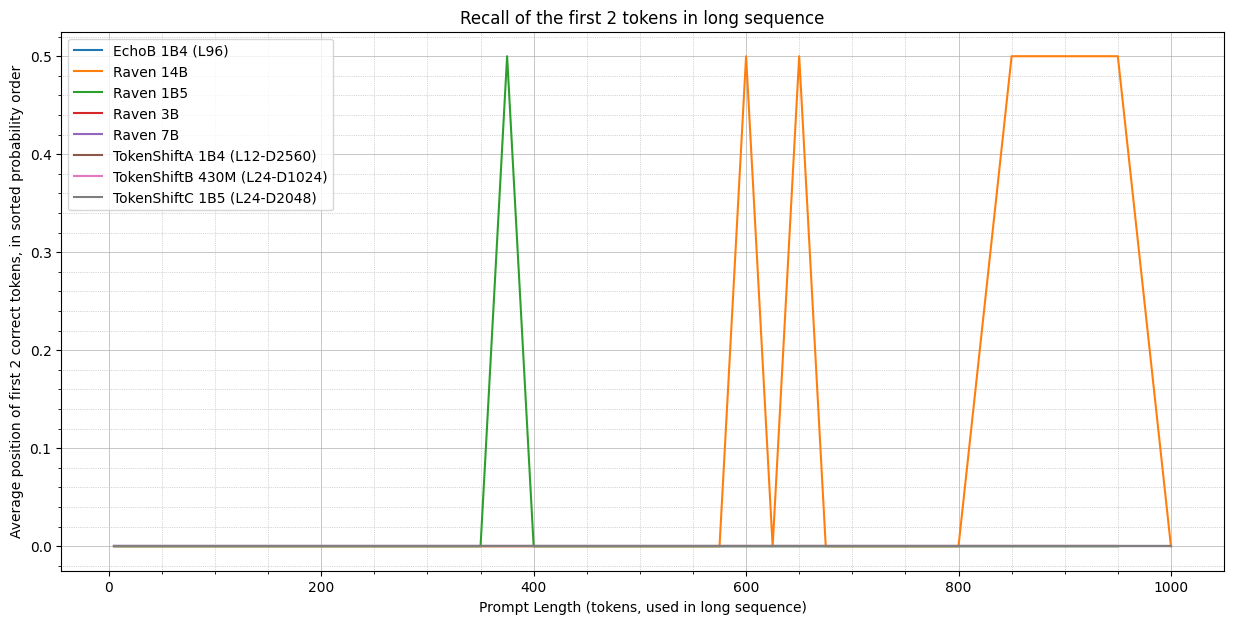

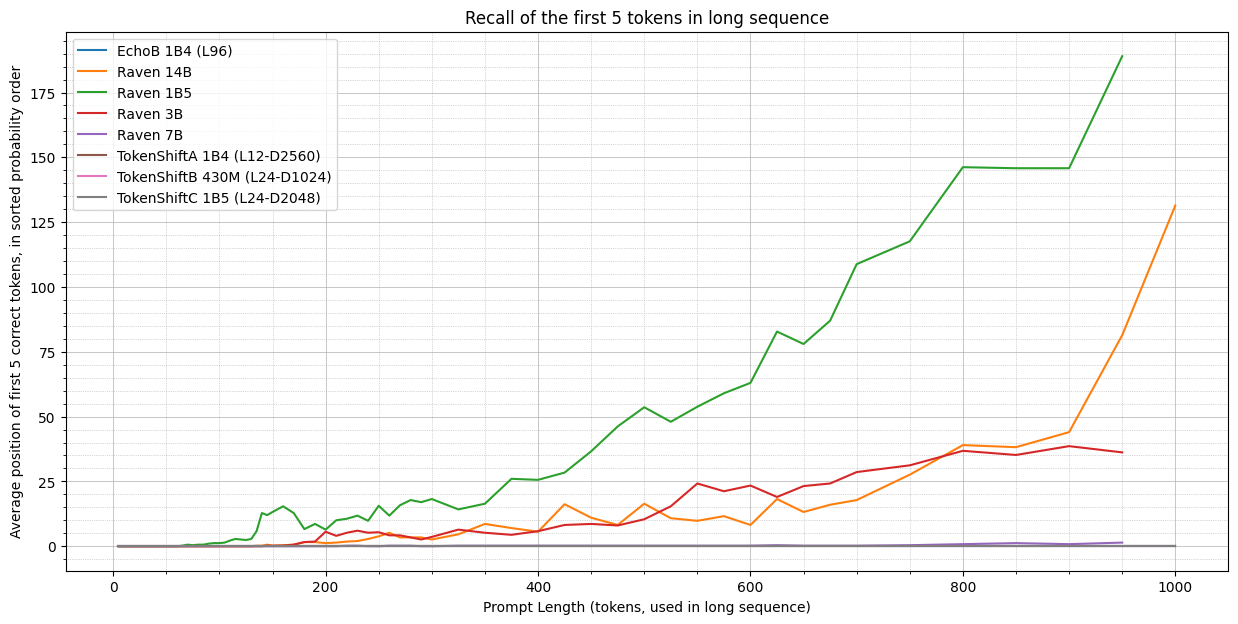

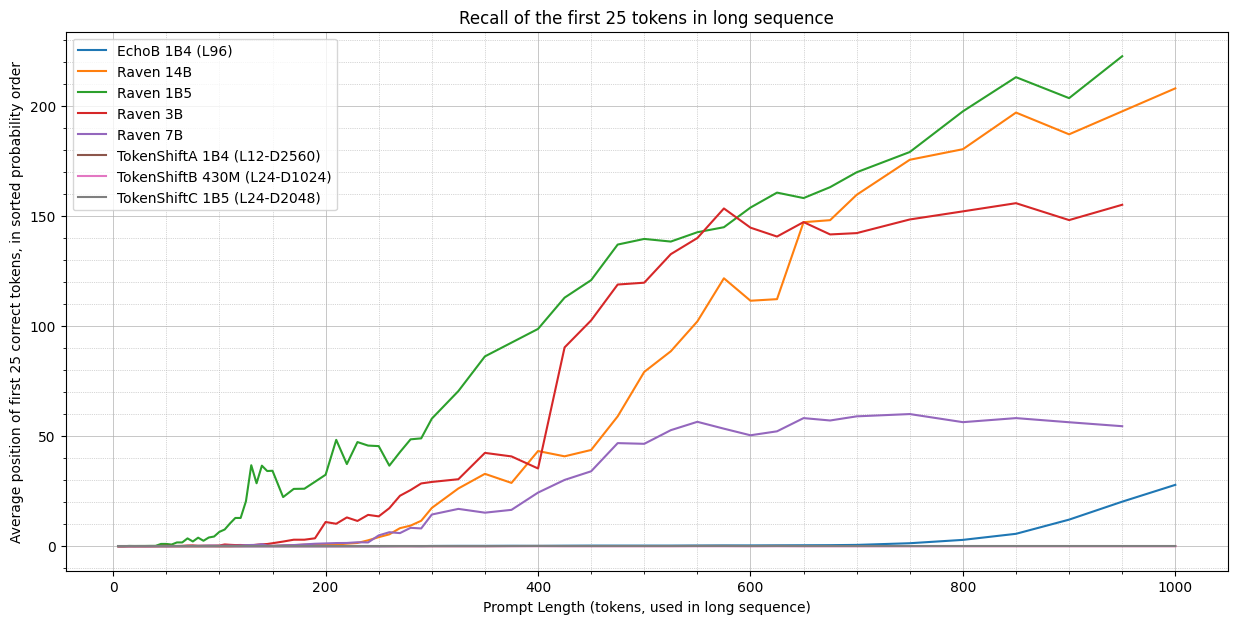

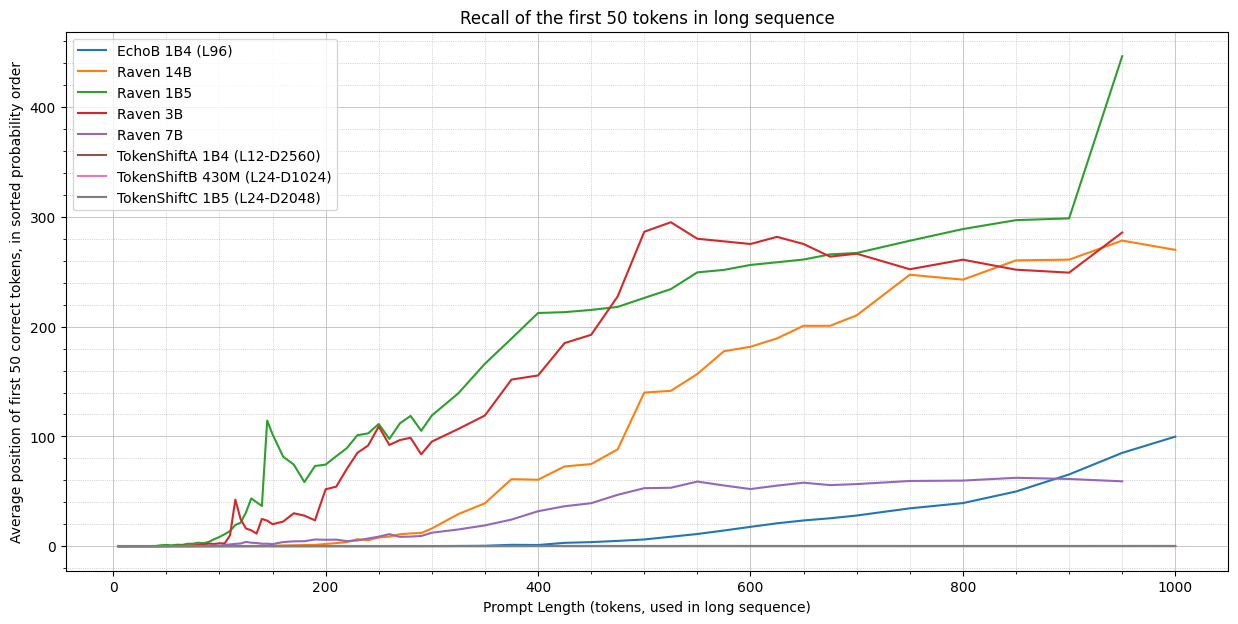

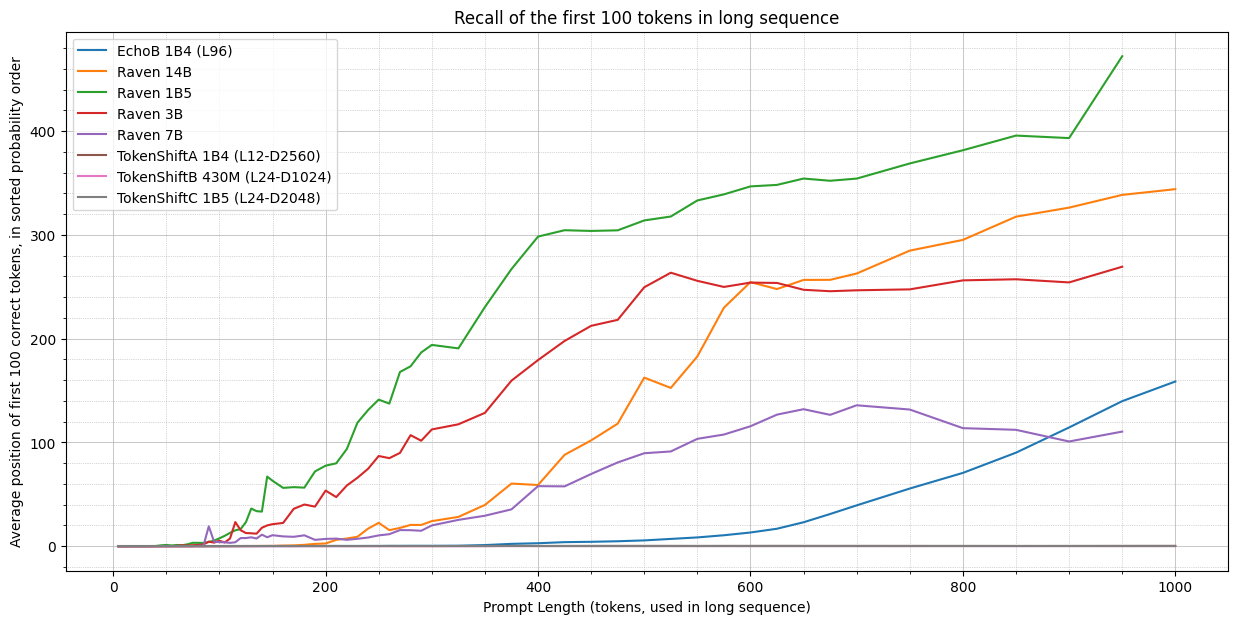

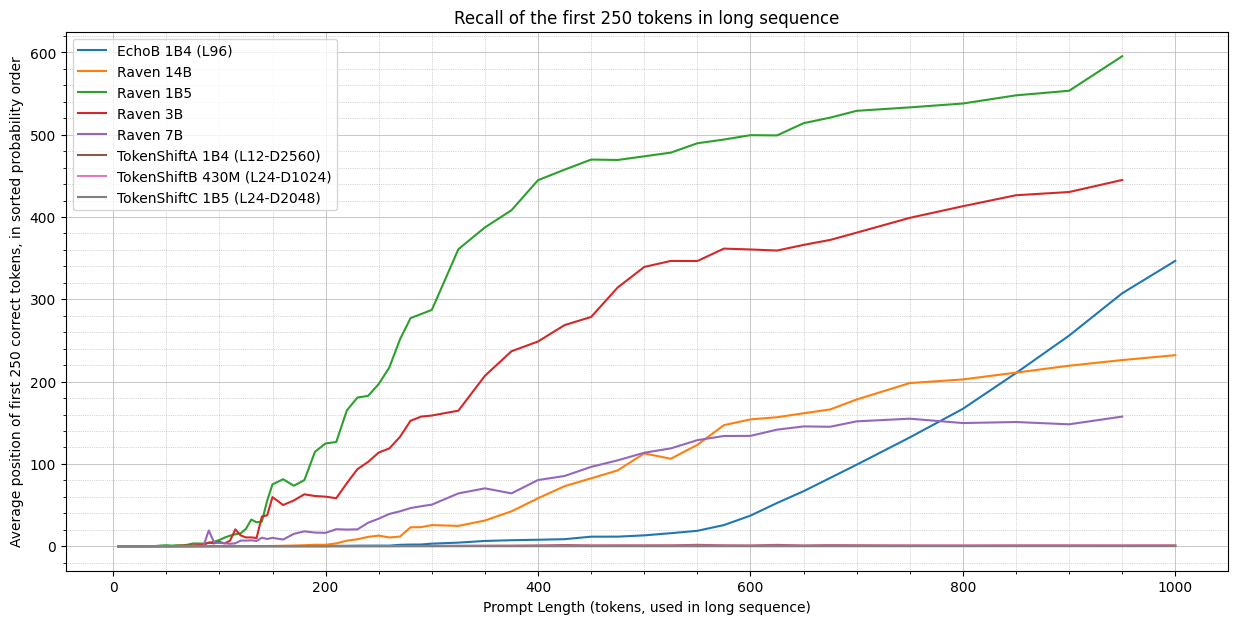

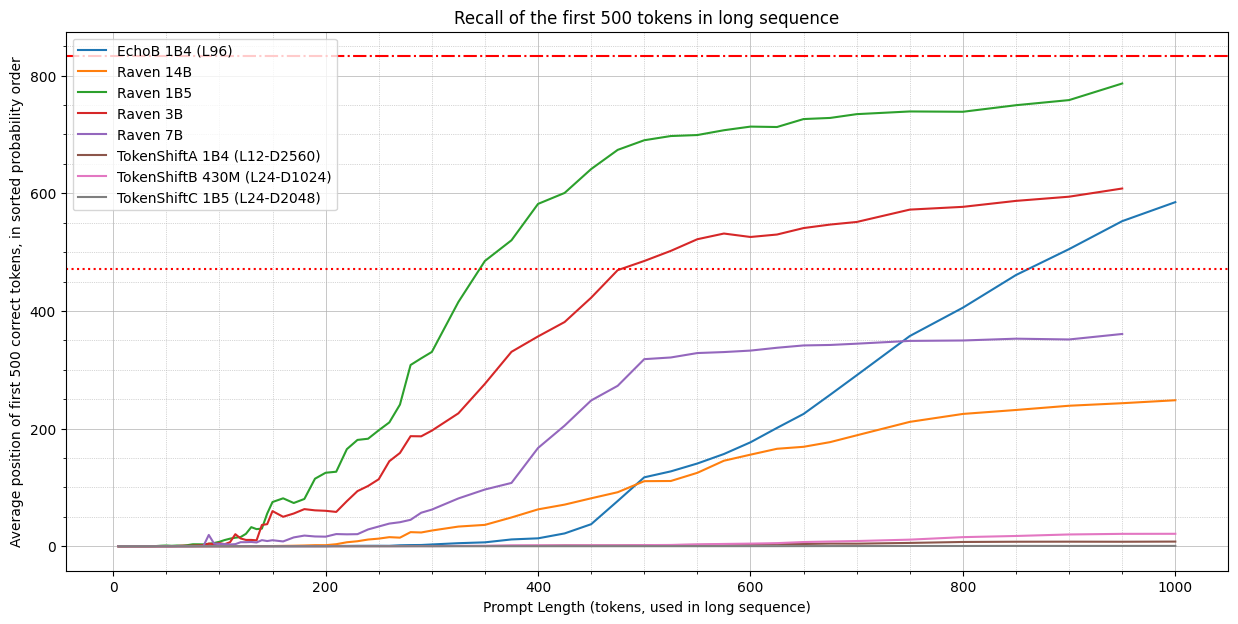

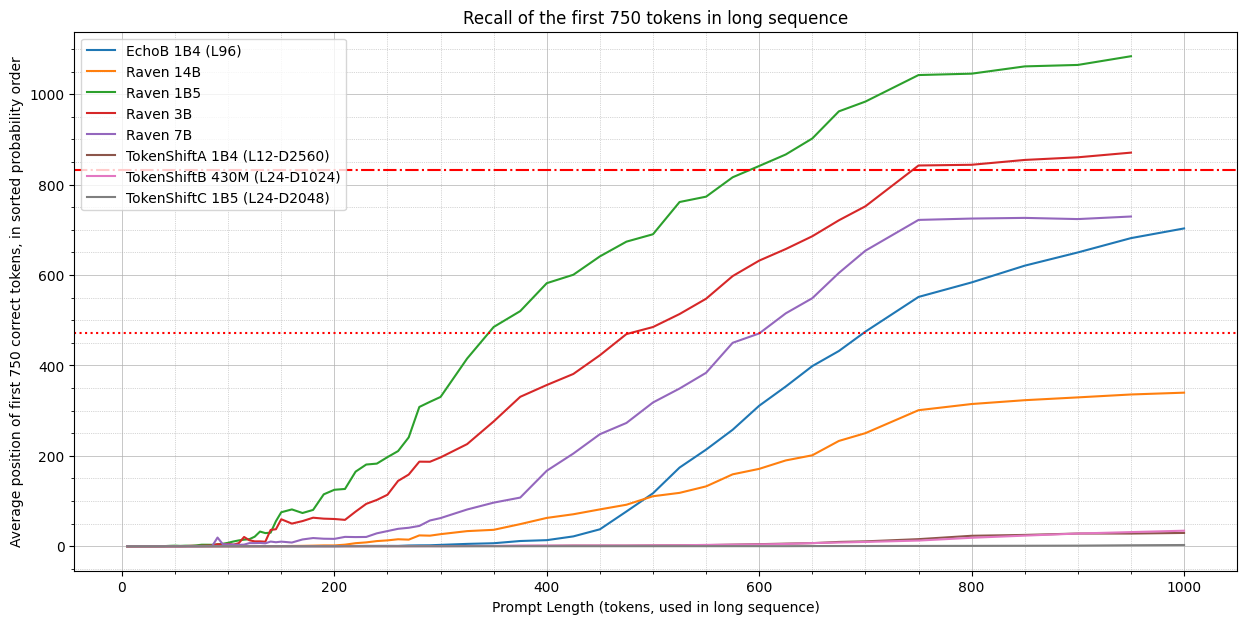

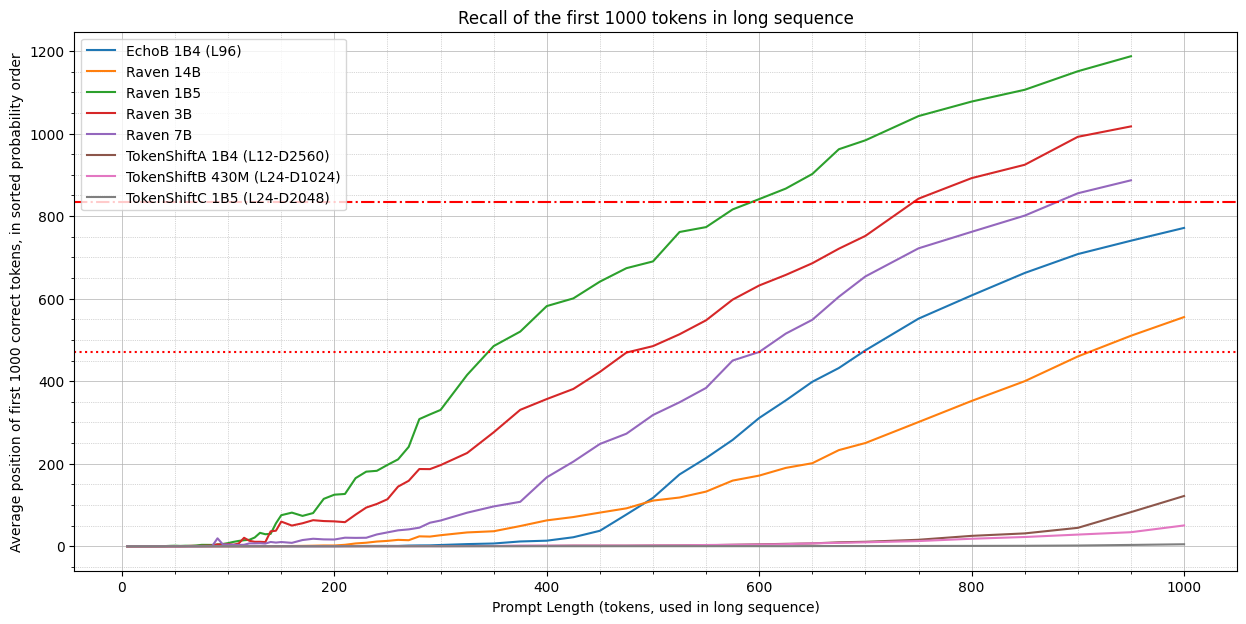

In [148]:
# Lets chart the first 2 tokens average for each model
plotGrapData([2])
plotGrapData([5])
plotGrapData([25])
plotGrapData([50])
plotGrapData([100])
plotGrapData([250])
plotGrapData([500], redline=True)
plotGrapData([750], redline=True)
plotGrapData([1000], redline=True)